# Feature Engineering

## 목표
- 시계열 특성 생성 (Lag features, Moving averages)
- 추세 및 변동성 지표
- 상대적 지표 (업종 내 순위)
- 고객 행동 지표
- 복합 지표
- Feature Selection

## 작업 내역
1. 전처리 데이터 로드
2. Lag Features (1, 3, 6, 12개월)
3. Moving Averages & Change Rates
4. Trend & Volatility Indicators
5. Relative Indicators (Industry Ranking)
6. Customer Behavior Indicators
7. Composite Indicators
8. Feature Selection
9. Feature Engineering 결과 저장

## 1. 환경 설정

In [27]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'DejaVu Sans'

# 출력 설정
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully")

Libraries loaded successfully


In [28]:
# 커스텀 모듈 임포트
import sys
sys.path.append('..')

from pipeline.features import (
    TimeSeriesFeatureEngine,
    CustomerFeatureEngine,
    CompositeFeatureEngine
)

print("Custom modules loaded successfully")

Custom modules loaded successfully


## 2. 데이터 로드

In [29]:
# 전처리된 데이터 로드
data_path = Path('../data/processed/preprocessed_data.csv')
df = pd.read_csv(data_path)

print(f"Loaded data shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
print(f"Rows: {len(df):,}")
print(f"Unique merchants: {df['ENCODED_MCT'].nunique():,}")
print(f"Date range: {df['TA_YM'].min()} ~ {df['TA_YM'].max()}")

Loaded data shape: (86590, 47)

Columns: 47
Rows: 86,590
Unique merchants: 4,185
Date range: 202301 ~ 202412


In [30]:
# 데이터 미리보기
df.head()

,ENCODED_MCT,TA_YM,MCT_OPE_MS_CN,RC_M1_SAA,RC_M1_TO_UE_CT,RC_M1_UE_CUS_CN,RC_M1_AV_NP_AT,APV_CE_RAT,DLV_SAA_RAT,M1_SME_RY_SAA_RAT,M1_SME_RY_CNT_RAT,M12_SME_RY_SAA_PCE_RT,M12_SME_BZN_SAA_PCE_RT,M12_SME_RY_ME_MCT_RAT,M12_SME_BZN_ME_MCT_RAT,M12_MAL_1020_RAT,M12_MAL_30_RAT,M12_MAL_40_RAT,M12_MAL_50_RAT,M12_MAL_60_RAT,M12_FME_1020_RAT,M12_FME_30_RAT,M12_FME_40_RAT,M12_FME_50_RAT,M12_FME_60_RAT,MCT_UE_CLN_REU_RAT,MCT_UE_CLN_NEW_RAT,RC_M1_SHC_RSD_UE_CLN_RAT,RC_M1_SHC_WP_UE_CLN_RAT,RC_M1_SHC_FLP_UE_CLN_RAT,MCT_BSE_AR,MCT_NM,MCT_BRD_NUM,MCT_SIGUNGU_NM,HPSN_MCT_ZCD_NM,HPSN_MCT_BZN_CD_NM,ARE_D,MCT_ME_D,months_until_close,will_close_1m,will_close_3m,is_valid_for_training,year,month,quarter,month_sin,month_cos
0,000F03E44A,202404,4,5,5,5,5,1.0,0.0,2.6,10.6,93.8,71.5,16.7,7.8,18.1818,9.0909,9.0909,18.1818,27.2727,4.0182,2.0091,2.0091,4.0182,6.0273,5.00,45.00,12.5,12.5,75.0,서울특별시 성동구 왕십리로4가길 9,육육**,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,20220225,NaN,NaN,0,0,1,2024,4,2,8.660254e-01,-0.500000
1,000F03E44A,202312,4,6,6,6,6,NaN,0.0,0.0,0.0,94.8,73.4,16.6,7.2,12.5083,37.4500,0.0000,24.9417,0.0000,4.1917,12.5500,0.0000,8.3583,0.0000,0.00,0.00,31.5,8.6,50.0,서울특별시 성동구 왕십리로4가길 9,육육**,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,20220225,NaN,NaN,0,0,1,2023,12,4,-2.449294e-16,1.000000
2,002816BA73,202404,2,3,4,4,2,6.0,0.0,96.6,40.8,15.6,20.0,17.5,5.2,5.4384,23.6488,20.0232,22.8248,10.4648,1.1616,5.0512,4.2768,4.8752,2.2352,10.66,6.12,23.8,23.8,52.4,서울 성동구 청계천로10나길 78,자갈***********,NaN,서울 성동구,요리주점,마장동,20140507,NaN,NaN,0,0,1,2024,4,2,8.660254e-01,-0.500000
3,002816BA73,202411,2,3,4,4,2,6.0,0.0,108.0,46.4,16.8,19.8,16.9,6.9,5.4855,18.9210,21.6240,20.5110,12.9585,1.4145,4.8790,5.5760,5.2890,3.3415,10.41,6.30,11.5,11.5,76.9,서울 성동구 청계천로10나길 78,자갈***********,NaN,서울 성동구,요리주점,마장동,20140507,NaN,NaN,0,0,1,2024,11,4,-5.000000e-01,0.866025
4,002816BA73,202406,2,4,4,4,2,1.0,0.0,74.2,38.1,16.0,19.9,17.3,5.6,5.3760,22.8480,21.0840,23.9400,10.7520,1.0240,4.3520,4.0160,4.5600,2.0480,9.86,4.69,13.0,17.4,69.6,서울 성동구 청계천로10나길 78,자갈***********,NaN,서울 성동구,요리주점,마장동,20140507,NaN,NaN,0,0,1,2024,6,2,1.224647e-16,-1.000000


In [31]:
# 데이터 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ENCODED_MCT               86590 non-null  object 
 1   TA_YM                     86590 non-null  int64  
 2   MCT_OPE_MS_CN             86590 non-null  int64  
 3   RC_M1_SAA                 86590 non-null  int64  
 4   RC_M1_TO_UE_CT            86590 non-null  int64  
 5   RC_M1_UE_CUS_CN           86590 non-null  int64  
 6   RC_M1_AV_NP_AT            86590 non-null  int64  
 7   APV_CE_RAT                79958 non-null  float64
 8   DLV_SAA_RAT               86590 non-null  float64
 9   M1_SME_RY_SAA_RAT         86590 non-null  float64
 10  M1_SME_RY_CNT_RAT         86590 non-null  float64
 11  M12_SME_RY_SAA_PCE_RT     86590 non-null  float64
 12  M12_SME_BZN_SAA_PCE_RT    86590 non-null  float64
 13  M12_SME_RY_ME_MCT_RAT     86590 non-null  float64
 14  M12_SM

## 3. Lag Features

시계열 데이터에서 과거 값을 현재 시점의 특성으로 사용합니다.
- 1개월 전 (lag_1m)
- 3개월 전 (lag_3m)
- 6개월 전 (lag_6m)
- 12개월 전 (lag_12m)

In [32]:
# TimeSeriesFeatureEngine 초기화
ts_engine = TimeSeriesFeatureEngine(
    merchant_col='ENCODED_MCT',
    date_col='TA_YM'
)

print("TimeSeriesFeatureEngine initialized")

TimeSeriesFeatureEngine initialized


In [33]:
# Lag feature를 생성할 주요 변수 선택
lag_columns = [
    # 매출 관련
    'MCT_OPE_MS_CN',  # 가맹점 운영 개월 수
    'RC_M1_SAA',  # 월 매출액
    'M1_SME_RY_SAA_RAT',  # 전월 대비 매출 증감률
    
    # 이용 건수/고객
    'RC_M1_TO_UE_CT',  # 총 이용 건수
    'RC_M1_UE_CUS_CN',  # 이용 고객 수
    'RC_M1_AV_NP_AT',  # 평균 결제 금액
    
    # 고객 재방문/신규
    'MCT_UE_CLN_REU_RAT',  # 재방문 고객 비율
    'MCT_UE_CLN_NEW_RAT',  # 신규 고객 비율
]

print(f"Selected {len(lag_columns)} columns for lag features")
print(f"Columns: {lag_columns}")

Selected 8 columns for lag features
Columns: ['MCT_OPE_MS_CN', 'RC_M1_SAA', 'M1_SME_RY_SAA_RAT', 'RC_M1_TO_UE_CT', 'RC_M1_UE_CUS_CN', 'RC_M1_AV_NP_AT', 'MCT_UE_CLN_REU_RAT', 'MCT_UE_CLN_NEW_RAT']


In [34]:
# Lag features 생성 (1, 3, 6, 12개월)
df_with_lags = ts_engine.create_lag_features(
    df,
    columns=lag_columns,
    lags=[1, 3, 6, 12]
)

print(f"\nShape after lag features: {df_with_lags.shape}")
print(f"New columns added: {df_with_lags.shape[1] - df.shape[1]}")


Creating lag features...
Columns: 8
Lags: [1, 3, 6, 12]
Created 32 lag features

Shape after lag features: (86590, 79)
New columns added: 32


In [35]:
# Lag feature 샘플 확인
sample_merchant = df_with_lags['ENCODED_MCT'].iloc[0]
sample_cols = ['ENCODED_MCT', 'TA_YM', 'RC_M1_SAA', 'RC_M1_SAA_lag_1m', 'RC_M1_SAA_lag_3m', 'RC_M1_SAA_lag_6m', 'RC_M1_SAA_lag_12m']

print(f"\nSample lag features for merchant {sample_merchant}:")
df_with_lags[df_with_lags['ENCODED_MCT'] == sample_merchant][sample_cols].head(15)


Sample lag features for merchant 000F03E44A:


,ENCODED_MCT,TA_YM,RC_M1_SAA,RC_M1_SAA_lag_1m,RC_M1_SAA_lag_3m,RC_M1_SAA_lag_6m,RC_M1_SAA_lag_12m
46117,000F03E44A,202301,6,NaN,NaN,NaN,NaN
27145,000F03E44A,202302,6,6.0,NaN,NaN,NaN
27144,000F03E44A,202303,6,6.0,NaN,NaN,NaN
51842,000F03E44A,202304,6,6.0,6.0,NaN,NaN
34110,000F03E44A,202305,6,6.0,6.0,NaN,NaN
49032,000F03E44A,202306,6,6.0,6.0,NaN,NaN
42387,000F03E44A,202307,6,6.0,6.0,6.0,NaN
18161,000F03E44A,202308,6,6.0,6.0,6.0,NaN
32547,000F03E44A,202309,6,6.0,6.0,6.0,NaN
12868,000F03E44A,202310,6,6.0,6.0,6.0,NaN


## 4. Moving Averages & Change Rates

추세를 파악하기 위한 이동평균과 증감률을 계산합니다.
- Moving averages: 3개월, 6개월, 12개월
- Change rates: 전월 대비, 전분기 대비, 전년 대비

In [36]:
# Moving averages 생성할 변수 선택
ma_columns = [
    'RC_M1_SAA',  # 월 매출액
    'RC_M1_TO_UE_CT',  # 총 이용 건수
    'RC_M1_UE_CUS_CN',  # 이용 고객 수
    'RC_M1_AV_NP_AT',  # 평균 결제 금액
    'MCT_UE_CLN_REU_RAT',  # 재방문 고객 비율
]

print(f"Selected {len(ma_columns)} columns for moving averages")

Selected 5 columns for moving averages


In [37]:
# Moving averages 생성 (3, 6, 12개월)
df_with_ma = ts_engine.create_moving_averages(
    df_with_lags,
    columns=ma_columns,
    windows=[3, 6, 12]
)

print(f"\nShape after moving averages: {df_with_ma.shape}")
print(f"New columns added: {df_with_ma.shape[1] - df_with_lags.shape[1]}")


Creating moving averages...
Columns: 5
Windows: [3, 6, 12]
Created 15 moving average features

Shape after moving averages: (86590, 94)
New columns added: 15


In [38]:
# Change rates 생성 (1개월, 3개월, 12개월 대비)
df_with_change = ts_engine.create_change_rates(
    df_with_ma,
    columns=ma_columns,
    periods=[1, 3, 12]
)

print(f"\nShape after change rates: {df_with_change.shape}")
print(f"New columns added: {df_with_change.shape[1] - df_with_ma.shape[1]}")


Creating change rates...
Columns: 5
Periods: [1, 3, 12]
Created 15 change rate features

Shape after change rates: (86590, 109)
New columns added: 15


In [39]:
# Moving average & change rate 샘플 확인
sample_cols = [
    'ENCODED_MCT', 'TA_YM', 
    'RC_M1_SAA', 
    'RC_M1_SAA_ma_3m', 'RC_M1_SAA_ma_6m', 'RC_M1_SAA_ma_12m',
    'RC_M1_SAA_change_1m', 'RC_M1_SAA_change_3m', 'RC_M1_SAA_change_12m'
]

available_cols = [col for col in sample_cols if col in df_with_change.columns]

print(f"\nSample moving averages and change rates for merchant {sample_merchant}:")
df_with_change[df_with_change['ENCODED_MCT'] == sample_merchant][available_cols].head(15)


Sample moving averages and change rates for merchant 000F03E44A:


,ENCODED_MCT,TA_YM,RC_M1_SAA,RC_M1_SAA_ma_3m,RC_M1_SAA_ma_6m,RC_M1_SAA_ma_12m,RC_M1_SAA_change_1m,RC_M1_SAA_change_3m,RC_M1_SAA_change_12m
46117,000F03E44A,202301,6,6.000000,6.000000,6.000000,NaN,NaN,NaN
27145,000F03E44A,202302,6,6.000000,6.000000,6.000000,0.000000,NaN,NaN
27144,000F03E44A,202303,6,6.000000,6.000000,6.000000,0.000000,NaN,NaN
51842,000F03E44A,202304,6,6.000000,6.000000,6.000000,0.000000,0.000000,NaN
34110,000F03E44A,202305,6,6.000000,6.000000,6.000000,0.000000,0.000000,NaN
49032,000F03E44A,202306,6,6.000000,6.000000,6.000000,0.000000,0.000000,NaN
42387,000F03E44A,202307,6,6.000000,6.000000,6.000000,0.000000,0.000000,NaN
18161,000F03E44A,202308,6,6.000000,6.000000,6.000000,0.000000,0.000000,NaN
32547,000F03E44A,202309,6,6.000000,6.000000,6.000000,0.000000,0.000000,NaN
12868,000F03E44A,202310,6,6.000000,6.000000,6.000000,0.000000,0.000000,NaN


## 5. Trend & Volatility Indicators

가맹점의 안정성과 추세를 나타내는 지표를 생성합니다.
- Trend: 매출 추세 (상승/하락/안정)
- Volatility: 매출 변동성 (표준편차, 변동계수)

In [40]:
# Trend & Volatility 지표 생성할 변수
trend_columns = [
    'RC_M1_SAA',  # 월 매출액
    'RC_M1_TO_UE_CT',  # 총 이용 건수
    'RC_M1_UE_CUS_CN',  # 이용 고객 수
]

print(f"Selected {len(trend_columns)} columns for trend & volatility")

Selected 3 columns for trend & volatility


In [41]:
# Trend indicators 생성 (3, 6, 12개월)
df_with_trend = ts_engine.create_trend_indicators(
    df_with_change,
    columns=trend_columns,
    windows=[3, 6, 12]
)

print(f"\nShape after trend indicators: {df_with_trend.shape}")
print(f"New columns added: {df_with_trend.shape[1] - df_with_change.shape[1]}")


Creating trend indicators...
Columns: 3
Windows: [3, 6, 12]
Created 9 trend indicator features

Shape after trend indicators: (86590, 118)
New columns added: 9


In [42]:
# Volatility indicators 생성 (3, 6, 12개월)
df_with_volatility = ts_engine.create_volatility_indicators(
    df_with_trend,
    columns=trend_columns,
    windows=[3, 6, 12]
)

print(f"\nShape after volatility indicators: {df_with_volatility.shape}")
print(f"New columns added: {df_with_volatility.shape[1] - df_with_trend.shape[1]}")


Creating volatility indicators...
Columns: 3
Windows: [3, 6, 12]
Created 18 volatility indicator features

Shape after volatility indicators: (86590, 136)
New columns added: 18


In [43]:
# Trend & Volatility 샘플 확인
sample_cols = [
    'ENCODED_MCT', 'TA_YM',
    'RC_M1_SAA',
    'RC_M1_SAA_trend_3m', 'RC_M1_SAA_trend_6m', 'RC_M1_SAA_trend_12m',
    'RC_M1_SAA_std_3m', 'RC_M1_SAA_std_6m', 'RC_M1_SAA_std_12m',
    'RC_M1_SAA_cv_3m', 'RC_M1_SAA_cv_6m', 'RC_M1_SAA_cv_12m'
]

available_cols = [col for col in sample_cols if col in df_with_volatility.columns]

print(f"\nSample trend & volatility indicators for merchant {sample_merchant}:")
df_with_volatility[df_with_volatility['ENCODED_MCT'] == sample_merchant][available_cols].head(15)


Sample trend & volatility indicators for merchant 000F03E44A:


,ENCODED_MCT,TA_YM,RC_M1_SAA,RC_M1_SAA_trend_3m,RC_M1_SAA_trend_6m,RC_M1_SAA_trend_12m,RC_M1_SAA_std_3m,RC_M1_SAA_std_6m,RC_M1_SAA_std_12m,RC_M1_SAA_cv_3m,RC_M1_SAA_cv_6m,RC_M1_SAA_cv_12m
46117,000F03E44A,202301,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27145,000F03E44A,202302,6,-6.280370e-16,-6.280370e-16,-6.280370e-16,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
27144,000F03E44A,202303,6,2.023645e-16,2.023645e-16,2.023645e-16,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
51842,000F03E44A,202304,6,2.023645e-16,5.138366e-17,5.138366e-17,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
34110,000F03E44A,202305,6,2.023645e-16,-8.302922e-16,-8.302922e-16,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
49032,000F03E44A,202306,6,2.023645e-16,-1.422096e-16,-1.422096e-16,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
42387,000F03E44A,202307,6,2.023645e-16,-1.422096e-16,3.883406e-17,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
18161,000F03E44A,202308,6,2.023645e-16,-1.422096e-16,-3.817634e-16,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
32547,000F03E44A,202309,6,2.023645e-16,-1.422096e-16,-6.839862e-17,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
12868,000F03E44A,202310,6,2.023645e-16,-1.422096e-16,9.632526e-17,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000


## 6. Relative Indicators (Industry Ranking)

업종 내에서의 상대적 위치를 나타내는 지표를 생성합니다.
- 월별 매출 순위
- 순위 변화 추이
- 업종 평균 대비 비율

In [44]:
# Relative ranking 지표 생성
ranking_columns = [
    'RC_M1_SAA',  # 월 매출액
    'RC_M1_TO_UE_CT',  # 총 이용 건수
    'RC_M1_UE_CUS_CN',  # 이용 고객 수
]

print(f"Selected {len(ranking_columns)} columns for relative ranking")

Selected 3 columns for relative ranking


In [45]:
# Ranking indicators 생성 (월별 순위)
df_with_ranking = ts_engine.create_ranking_indicators(
    df_with_volatility,
    columns=ranking_columns
)

print(f"\nShape after ranking indicators: {df_with_ranking.shape}")
print(f"New columns added: {df_with_ranking.shape[1] - df_with_volatility.shape[1]}")


Creating ranking indicators...
Columns: 3
Created 6 ranking features

Shape after ranking indicators: (86590, 142)
New columns added: 6


In [46]:
# Ranking change 생성 (순위 변화)
df_with_rank_change = ts_engine.create_ranking_change(
    df_with_ranking,
    columns=ranking_columns,
    periods=[1, 3, 6]
)

print(f"\nShape after ranking change: {df_with_rank_change.shape}")
print(f"New columns added: {df_with_rank_change.shape[1] - df_with_ranking.shape[1]}")


Creating ranking change indicators...
Columns: 3
Periods: [1, 3, 6]
Created 9 ranking change features

Shape after ranking change: (86590, 151)
New columns added: 9


In [47]:
# Ranking 샘플 확인
sample_cols = [
    'ENCODED_MCT', 'TA_YM',
    'RC_M1_SAA',
    'RC_M1_SAA_rank', 'RC_M1_SAA_rank_pct',
    'RC_M1_SAA_rank_change_1m', 'RC_M1_SAA_rank_change_3m', 'RC_M1_SAA_rank_change_6m'
]

available_cols = [col for col in sample_cols if col in df_with_rank_change.columns]

print(f"\nSample ranking indicators for merchant {sample_merchant}:")
df_with_rank_change[df_with_rank_change['ENCODED_MCT'] == sample_merchant][available_cols].head(15)


Sample ranking indicators for merchant 000F03E44A:


,ENCODED_MCT,TA_YM,RC_M1_SAA,RC_M1_SAA_rank,RC_M1_SAA_rank_pct,RC_M1_SAA_rank_change_1m,RC_M1_SAA_rank_change_3m,RC_M1_SAA_rank_change_6m
46117,000F03E44A,202301,6,1.0,96.128822,NaN,NaN,NaN
27145,000F03E44A,202302,6,1.0,95.582070,0.0,NaN,NaN
27144,000F03E44A,202303,6,1.0,95.900858,0.0,NaN,NaN
51842,000F03E44A,202304,6,1.0,95.521223,0.0,0.0,NaN
34110,000F03E44A,202305,6,1.0,95.820481,0.0,0.0,NaN
49032,000F03E44A,202306,6,1.0,95.660780,0.0,0.0,NaN
42387,000F03E44A,202307,6,1.0,95.405405,0.0,0.0,0.0
18161,000F03E44A,202308,6,1.0,95.214180,0.0,0.0,0.0
32547,000F03E44A,202309,6,1.0,95.952242,0.0,0.0,0.0
12868,000F03E44A,202310,6,1.0,95.614035,0.0,0.0,0.0


## 7. Customer Behavior Indicators

고객 행동 패턴을 나타내는 지표를 생성합니다.
- 재방문율 추이
- 신규 고객 비율 추이
- 고객 충성도 지표

In [48]:
# CustomerFeatureEngine 초기화
customer_engine = CustomerFeatureEngine(
    merchant_col='ENCODED_MCT',
    date_col='TA_YM'
)

print("CustomerFeatureEngine initialized")

CustomerFeatureEngine initialized


In [49]:
# Customer behavior indicators 생성
df_with_customer = customer_engine.create_customer_behavior_features(
    df_with_rank_change,
    windows=[3, 6, 12]
)

print(f"\nShape after customer behavior features: {df_with_customer.shape}")
print(f"New columns added: {df_with_customer.shape[1] - df_with_rank_change.shape[1]}")


Creating customer behavior features...
Windows: [3, 6, 12]
Created 12 customer behavior features

Shape after customer behavior features: (86590, 163)
New columns added: 12


In [50]:
# Customer loyalty indicators 생성
df_with_loyalty = customer_engine.create_loyalty_indicators(
    df_with_customer,
    windows=[3, 6, 12]
)

print(f"\nShape after loyalty indicators: {df_with_loyalty.shape}")
print(f"New columns added: {df_with_loyalty.shape[1] - df_with_customer.shape[1]}")


Creating loyalty indicators...
Windows: [3, 6, 12]
Created 10 loyalty indicator features

Shape after loyalty indicators: (86590, 173)
New columns added: 10


## 8. Composite Indicators

여러 feature를 조합하여 복합 지표를 생성합니다.
- 가맹점 건강도 지수
- 리스크 지수
- 성장 지수

In [51]:
# CompositeFeatureEngine 초기화
composite_engine = CompositeFeatureEngine()

print("CompositeFeatureEngine initialized")

CompositeFeatureEngine initialized


In [52]:
# Composite indicators 생성
df_with_composite = composite_engine.create_composite_indicators(
    df_with_loyalty
)

print(f"\nShape after composite indicators: {df_with_composite.shape}")
print(f"New columns added: {df_with_composite.shape[1] - df_with_loyalty.shape[1]}")


Creating composite indicators...
Created 9 composite indicator features

Shape after composite indicators: (86590, 182)
New columns added: 9


## 9. Feature Selection

생성된 feature 중 중요한 변수를 선별합니다.
- 결측값 비율 확인
- 분산 확인
- 상관관계 분석

In [53]:
# 결측값 비율 확인
missing_ratio = df_with_composite.isnull().sum() / len(df_with_composite) * 100
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)

print(f"Columns with missing values: {len(missing_ratio)}")
print(f"\nTop 20 columns with highest missing ratio:")
print(missing_ratio.head(20))

Columns with missing values: 113

Top 20 columns with highest missing ratio:
months_until_close               97.304539
MCT_ME_D                         97.304539
MCT_BRD_NUM                      86.459175
MCT_UE_CLN_REU_RAT_change_12m    55.496016
M1_SME_RY_SAA_RAT_lag_12m        54.259152
RC_M1_SAA_lag_12m                54.259152
MCT_UE_CLN_REU_RAT_lag_12m       54.259152
RC_M1_UE_CUS_CN_lag_12m          54.259152
MCT_OPE_MS_CN_lag_12m            54.259152
MCT_UE_CLN_NEW_RAT_lag_12m       54.259152
RC_M1_SAA_change_12m             54.259152
RC_M1_UE_CUS_CN_change_12m       54.259152
RC_M1_TO_UE_CT_change_12m        54.259152
RC_M1_AV_NP_AT_lag_12m           54.259152
RC_M1_TO_UE_CT_lag_12m           54.259152
growth_index_12m                 54.259152
RC_M1_AV_NP_AT_change_12m        54.259152
M1_SME_RY_SAA_RAT_lag_6m         28.242291
RC_M1_AV_NP_AT_lag_6m            28.242291
MCT_UE_CLN_NEW_RAT_lag_6m        28.242291
dtype: float64


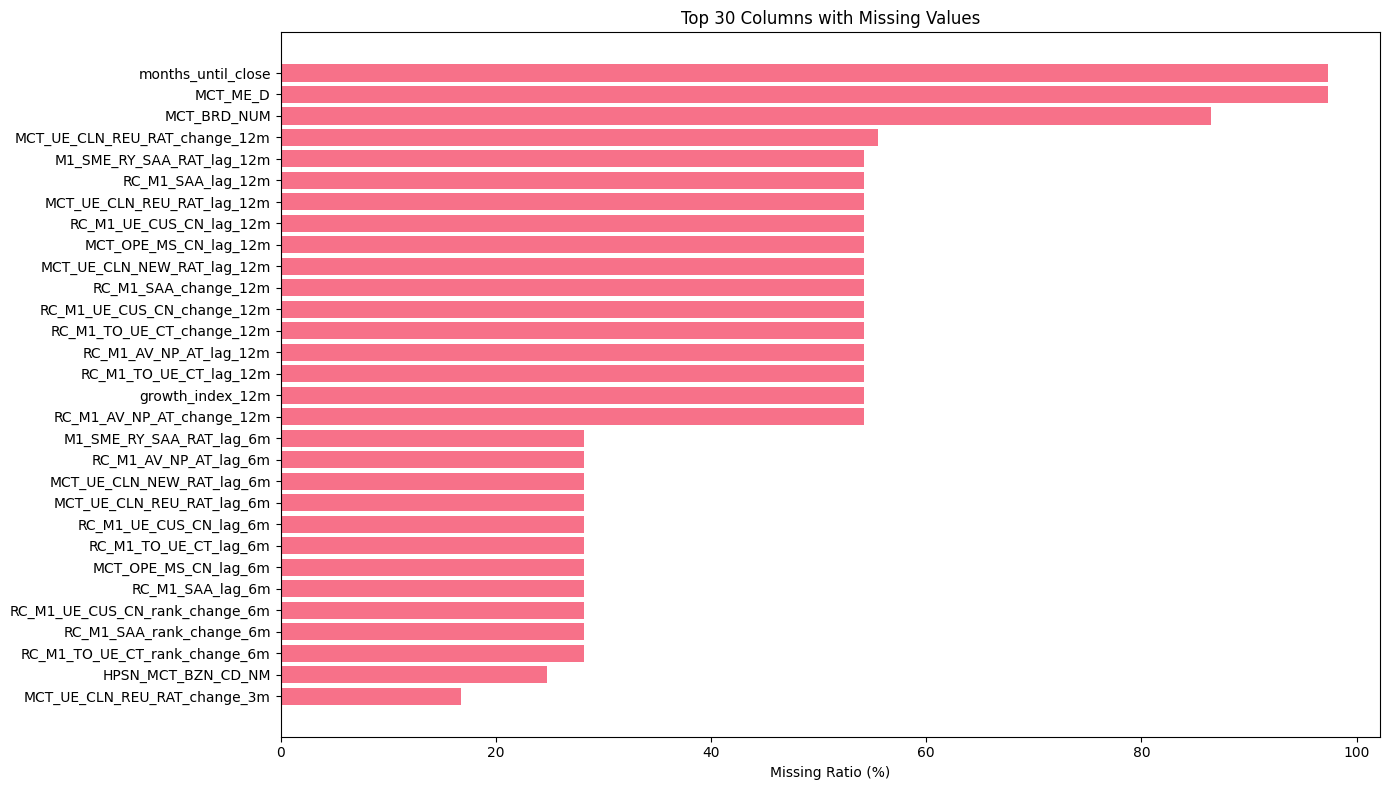

In [54]:
# 결측값 시각화
if len(missing_ratio) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    top_missing = missing_ratio.head(30)
    ax.barh(range(len(top_missing)), top_missing.values)
    ax.set_yticks(range(len(top_missing)))
    ax.set_yticklabels(top_missing.index)
    ax.set_xlabel('Missing Ratio (%)')
    ax.set_title('Top 30 Columns with Missing Values')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

In [55]:
# 수치형 변수 선택
numeric_cols = df_with_composite.select_dtypes(include=[np.number]).columns.tolist()

# ID, 타겟 변수 제외
exclude_cols = ['ENCODED_MCT', 'TA_YM', 'will_close_1m', 'will_close_3m', 'months_until_close', 'is_valid_for_training']
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"\nTotal numeric features: {len(feature_cols)}")
print(f"Features: {feature_cols[:20]}...")


Total numeric features: 170
Features: ['MCT_OPE_MS_CN', 'RC_M1_SAA', 'RC_M1_TO_UE_CT', 'RC_M1_UE_CUS_CN', 'RC_M1_AV_NP_AT', 'APV_CE_RAT', 'DLV_SAA_RAT', 'M1_SME_RY_SAA_RAT', 'M1_SME_RY_CNT_RAT', 'M12_SME_RY_SAA_PCE_RT', 'M12_SME_BZN_SAA_PCE_RT', 'M12_SME_RY_ME_MCT_RAT', 'M12_SME_BZN_ME_MCT_RAT', 'M12_MAL_1020_RAT', 'M12_MAL_30_RAT', 'M12_MAL_40_RAT', 'M12_MAL_50_RAT', 'M12_MAL_60_RAT', 'M12_FME_1020_RAT', 'M12_FME_30_RAT']...


In [56]:
# 분산이 0인 변수 확인
zero_var_cols = df_with_composite[feature_cols].var()[df_with_composite[feature_cols].var() == 0].index.tolist()

if zero_var_cols:
    print(f"\nColumns with zero variance: {len(zero_var_cols)}")
    print(zero_var_cols)
else:
    print("\nNo columns with zero variance found")


No columns with zero variance found



Top 30 features correlated with 'will_close_3m':
MCT_ME_D                      0.470438
DLV_SAA_RAT                   0.026869
MCT_OPE_MS_CN_lag_12m         0.021209
MCT_UE_CLN_REU_RAT_lag_12m    0.015970
ARE_D                         0.013857
MCT_OPE_MS_CN_lag_6m          0.012597
health_index_6m               0.010804
MCT_OPE_MS_CN_lag_3m          0.010732
customer_new_avg_12m          0.010623
RC_M1_UE_CUS_CN_lag_12m       0.010526
MCT_OPE_MS_CN_lag_1m          0.010460
M12_MAL_1020_RAT              0.010403
customer_new_avg_6m           0.010138
customer_new_avg_3m           0.009988
health_index_3m               0.009951
MCT_OPE_MS_CN                 0.009932
RC_M1_SAA_cv_12m              0.009763
RC_M1_TO_UE_CT_lag_12m        0.009254
RC_M1_SHC_RSD_UE_CLN_RAT      0.009246
RC_M1_SAA_cv_6m               0.009230
RC_M1_TO_UE_CT_std_12m        0.009142
MCT_UE_CLN_NEW_RAT_lag_3m     0.008953
risk_index_12m                0.008901
MCT_UE_CLN_NEW_RAT_lag_1m     0.008551
risk_index_6m 

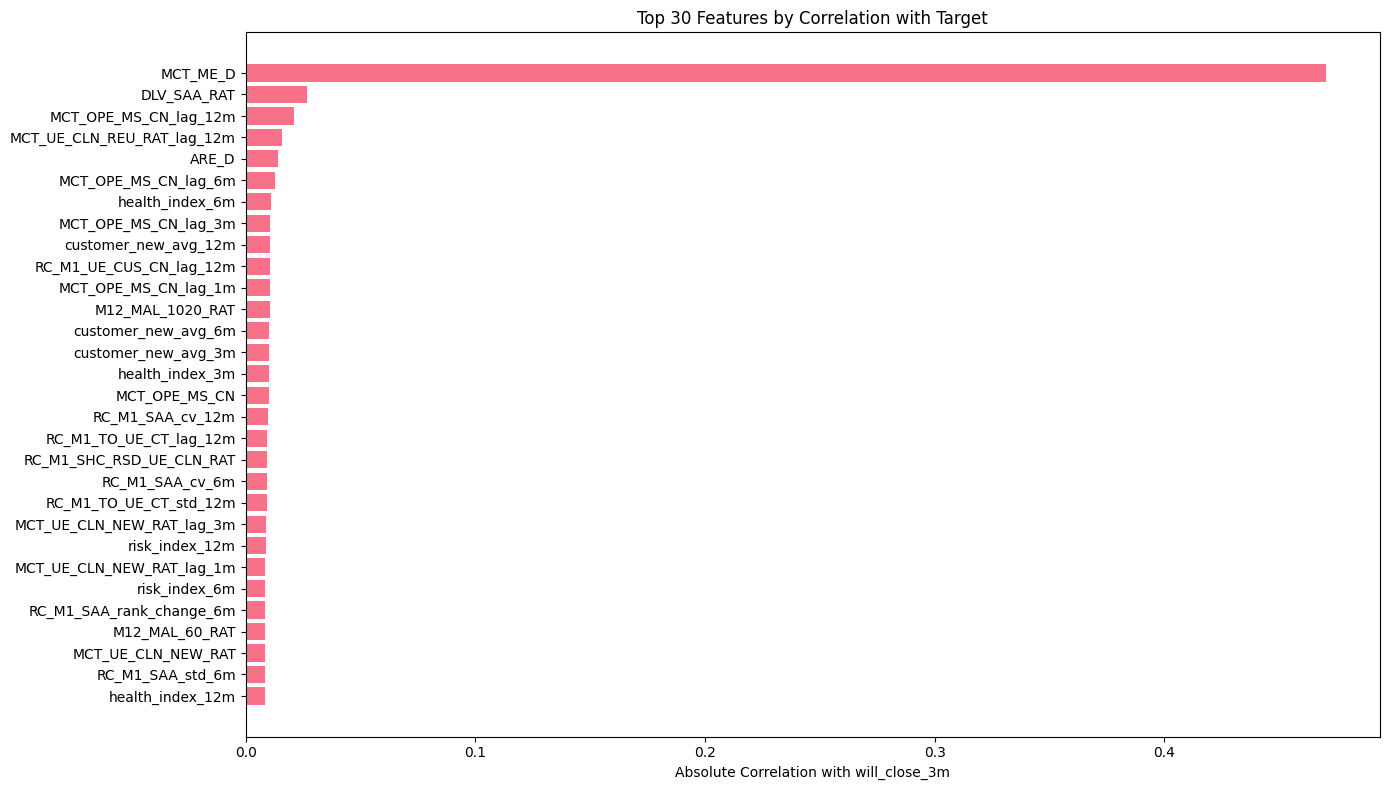

In [57]:
# 타겟 변수와의 상관관계 확인 (will_close_3m)
if 'will_close_3m' in df_with_composite.columns:
    correlations = df_with_composite[feature_cols].corrwith(df_with_composite['will_close_3m']).abs().sort_values(ascending=False)
    
    print("\nTop 30 features correlated with 'will_close_3m':")
    print(correlations.head(30))
    
    # 시각화
    fig, ax = plt.subplots(figsize=(14, 8))
    top_corr = correlations.head(30)
    ax.barh(range(len(top_corr)), top_corr.values)
    ax.set_yticks(range(len(top_corr)))
    ax.set_yticklabels(top_corr.index)
    ax.set_xlabel('Absolute Correlation with will_close_3m')
    ax.set_title('Top 30 Features by Correlation with Target')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

## 10. Feature Engineering 결과 저장

In [58]:
# 최종 데이터 정보
print("="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

print(f"\nFinal Shape: {df_with_composite.shape}")
print(f"Total Columns: {len(df_with_composite.columns)}")
print(f"Total Rows: {len(df_with_composite):,}")
print(f"Unique Merchants: {df_with_composite['ENCODED_MCT'].nunique():,}")
print(f"Date Range: {df_with_composite['TA_YM'].min()} ~ {df_with_composite['TA_YM'].max()}")
print(f"Memory Usage: {df_with_composite.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nOriginal columns: {df.shape[1]}")
print(f"Engineered features: {df_with_composite.shape[1] - df.shape[1]}")
print(f"Missing Values: {df_with_composite.isnull().sum().sum():,}")

FEATURE ENGINEERING SUMMARY

Final Shape: (86590, 182)
Total Columns: 182
Total Rows: 86,590
Unique Merchants: 4,185
Date Range: 202301 ~ 202412
Memory Usage: 156.97 MB

Original columns: 47
Engineered features: 135
Missing Values: 1,713,423


In [59]:
# Feature engineering 데이터 저장
output_path = Path('../data/processed')
output_path.mkdir(exist_ok=True)

# CSV 저장
csv_path = output_path / 'featured_data.csv'
df_with_composite.to_csv(csv_path, index=False)
print(f"\nSaved to: {csv_path}")
print(f"File size: {csv_path.stat().st_size / 1024**2:.2f} MB")


Saved to: ../data/processed/featured_data.csv
File size: 141.15 MB


In [60]:
# Feature list 저장
feature_list = {
    'total_features': len(feature_cols),
    'feature_columns': feature_cols,
    'lag_features': [col for col in df_with_composite.columns if '_lag_' in col],
    'ma_features': [col for col in df_with_composite.columns if '_ma_' in col],
    'change_features': [col for col in df_with_composite.columns if '_change_' in col],
    'trend_features': [col for col in df_with_composite.columns if '_trend_' in col],
    'volatility_features': [col for col in df_with_composite.columns if '_std_' in col or '_cv_' in col],
    'ranking_features': [col for col in df_with_composite.columns if '_rank' in col],
    'customer_features': [col for col in df_with_composite.columns if 'customer_' in col or 'loyalty_' in col],
    'composite_features': [col for col in df_with_composite.columns if 'health_' in col or 'risk_' in col or 'growth_' in col],
}

import json
feature_path = output_path / 'feature_list.json'
with open(feature_path, 'w') as f:
    json.dump(feature_list, f, indent=2)

print(f"\nFeature list saved to: {feature_path}")


Feature list saved to: ../data/processed/feature_list.json


In [61]:
# Feature 통계 요약
print("\nFeature Statistics:")
for key, value in feature_list.items():
    if key != 'feature_columns':
        if isinstance(value, list):
            print(f"{key}: {len(value)}")
        else:
            print(f"{key}: {value}")


Feature Statistics:
total_features: 170
lag_features: 32
ma_features: 15
change_features: 24
trend_features: 15
volatility_features: 21
ranking_features: 15
customer_features: 22
composite_features: 9


## 11. 결론

### 완료된 작업
1. ✅ Lag Features 생성 (1, 3, 6, 12개월)
2. ✅ Moving Averages & Change Rates
3. ✅ Trend & Volatility Indicators
4. ✅ Relative Indicators (Ranking)
5. ✅ Customer Behavior Indicators
6. ✅ Composite Indicators
7. ✅ Feature Selection & Analysis
8. ✅ Feature Engineering 결과 저장

### 다음 단계 (Week 3)
- 모델 학습 및 평가
  - XGBoost, LightGBM 모델 학습
  - Cross-validation
  - Hyperparameter tuning
  - Feature importance 분석
  - SHAP value 분석
  - 앙상블 모델

In [62]:
print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETED")
print("="*80)
print(f"\nFinal dataset: {df_with_composite.shape}")
print(f"Saved to: {csv_path}")
print("\nReady for Model Training!")


FEATURE ENGINEERING COMPLETED

Final dataset: (86590, 182)
Saved to: ../data/processed/featured_data.csv

Ready for Model Training!
